# Import Libraries

In [1]:
# numpy
import numpy as np

# pandas
import pandas as pd

#scipy
from scipy.stats import boxcox

# math
import math

# matplotlib
import matplotlib.pyplot as plt

# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# sklearn 
from sklearn.metrics import mean_squared_error

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
# Load dataset
data = pd.Series.from_csv(path='Data/robberies.csv', header=0)

# split dataset
split_point = len(data) - 10

# dataset (observation from year 1966 to 1974)
# dev_data (observations of year 1975)
train_data , dev_data = data[0:split_point], data[split_point:]

### Data Preparation: We have monthly dataset for 9 years (1966-1975), we split the dataset into two parts 
1- train_data (observation from year 1966 to 1974), will use this for training. <br> 
2- dev_data (observations of year 1975), will take this as a development set.

# Persistance Model (For Baseline RMSE)

In [3]:
# walk-forward validation model
history = [i for i in train_data]
predictions = []

for i in range(len(dev_data)):
    
    # get prediction
    y_pred = history[-1]
    predictions.append(y_pred)
    
    # observed
    y_true = dev_data[i]
    history.append(y_true)
    print('Predicted: %.2f, Expected: %.3f' % (y_pred, y_true))
    
print('\nBaseline RMSE : %.2f' % (np.sqrt(mean_squared_error(dev_data, predictions))))

Predicted: 391.00, Expected: 500.000
Predicted: 500.00, Expected: 451.000
Predicted: 451.00, Expected: 375.000
Predicted: 375.00, Expected: 372.000
Predicted: 372.00, Expected: 302.000
Predicted: 302.00, Expected: 316.000
Predicted: 316.00, Expected: 398.000
Predicted: 398.00, Expected: 394.000
Predicted: 394.00, Expected: 431.000
Predicted: 431.00, Expected: 431.000

Baseline RMSE : 57.68


### Analysis (Persistance Model): 
We got RMSE value of <b>57.68 </b> which will act as a baseline value for improvement of ARIMA model.

# Data Analysis

### Summary Statistics

In [4]:
train_data.describe()

count    108.000000
mean     177.703704
std      116.231260
min       29.000000
25%       76.250000
50%      149.000000
75%      276.750000
max      487.000000
Name: Robberies, dtype: float64

### Line Plot

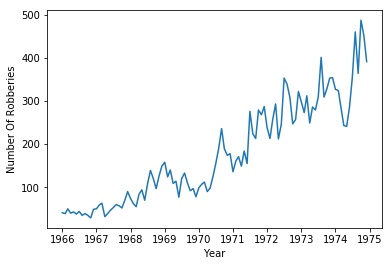

In [5]:
plt.plot(train_data)
plt.xlabel('Year')
plt.ylabel('Number Of Robberies')
plt.show()

#### Analysis (Line Plot): Following observations can be made from above line plot
1- An increasing trend in observed from year to year. We will detrend it .<br>
2- Data is not stationary seems like it has varying mean and variance over time (years). We will remove seasonality .<br>
3- Large fluctions are observed from year to year. <br>
    * Earlier year posess less fluctuations .
    * Later years posess more fluctuations.

### Density Plot

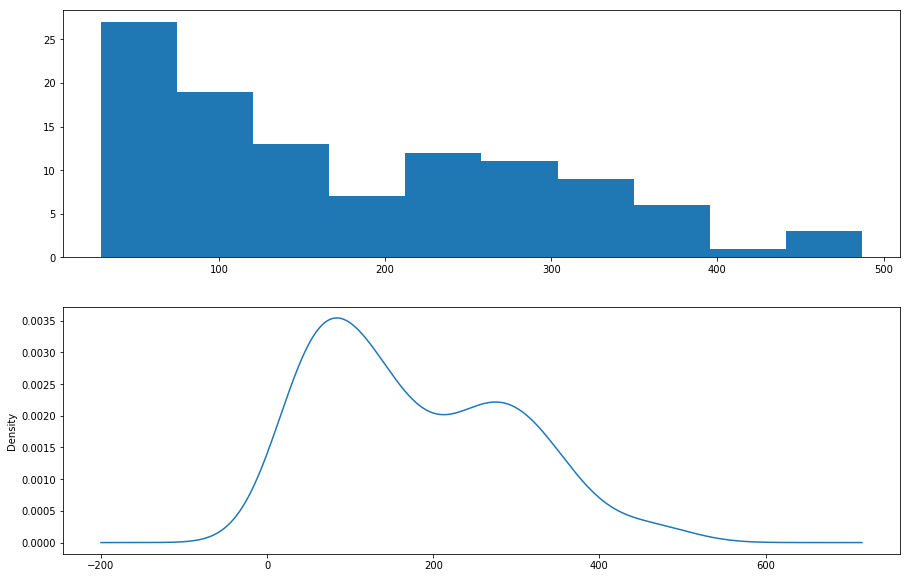

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.hist(train_data)
plt.subplot(212)
train_data.plot(kind='kde')
plt.show()

#### Analysis (Density Plot): Following observations can be made from above Density plots
1- The histogram shows exponential distribution | long tailed towards right. This can be removed using log power transform. <br>
2- The density plot shows a bimodal distribution. <br>

### Box and Whisker Plot

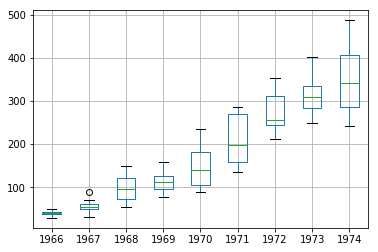

In [7]:
# Groupby year
dataset_gp_byyear = train_data.groupby(pd.TimeGrouper('A'))

# Create a dataframe of groupby values
year = pd.DataFrame()
for date, monthly_values in dataset_gp_byyear:
    year[date.year] = monthly_values.values
    
# Plot Boxplot
year.boxplot()
plt.show()

#### Analysis (Boxplot): 
#### Following observation can be made from above boxplot :
1- The yearwise change in distribution shows that trend may not be linear. <br>

# ARIMA MODEL

#### First lets do a statistical stationarity test (ADF test) on the dataset

In [8]:
# ADF test
result = adfuller(train_data)
print('p-value %.2f' % (result[1]))

p-value 0.99


#### Analysis (ADF test): 
#### Following observation can be made from above p-value :
1- Given p-value of 0.99 seems like null hypothesis is accepted meaning that the data is not stationary and ARIMA model assumes data to be stationary, lets first make it stationary and then do ADF test<br>

In [9]:
# Make dataset stationary by differencing
dataset_no_trend = pd.Series([ train_data[i]- train_data[i-1] for i in range(1, len(train_data))], index=train_data.index[1:])

In [10]:
print('p-value after detrending : %f' % (adfuller(dataset_no_trend)[1]))

p-value after detrending : 0.000417


#### Analysis (Post differencing): 
#### Following observation can be made from above p-value :
1- Given p-value of 0.000417 seems like null hypothesis is rejected meaning that the data is stationary and we can model ARIMA on it, suggesting 1-level differencing is required.<br>

### Find AR-MA parameters of ARIMA model using ACF and PACF plot

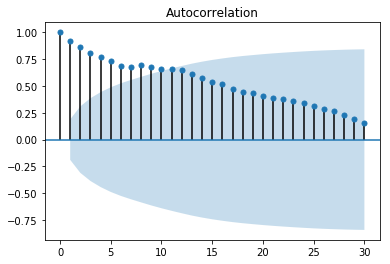

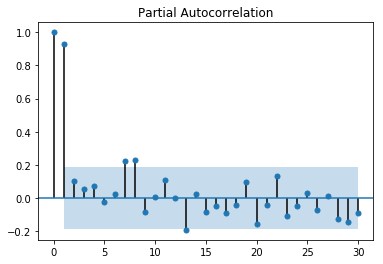

In [11]:
plot_acf(train_data,lags=30)
plt.show()
plot_pacf(train_data, lags=30)
plt.show()

#### Analysis (ACF And PACF): 
#### Following observation can be made from above plots :
1- From ACF plot it can be observed that lag uptill 10 shows great correlation so will consider value of p=10 hence its an AR(10) process. <br>
2- From PACF plot it can be observed that lag values uptill 2 so will consider value of q=2 hence its an MA(2) process. <br>
3- Since, from the previous differencing part we found that d=1 makes the time series stationary, hence will take value of d=1. <br>

### ARIMA MODEL (Manually configured) - Walk Forward Style Validation

In [12]:
def ARIMA_mannaul(order, train, test):
    
    history = [i for i in train]
    predictions = []
    
    for i in range(len(test)):
        
        # Fit model and predict
        model = ARIMA(history, order=order)
        
        try : 
            y_pred = model.fit(disp=0).forecast()[0]
            predictions.append(y_pred)
            
        except: 
            continue      
        
        # y_true
        y_true = test[i]
        history.append(y_true)
        
    try :
        # Model performance
        rmse = np.sqrt(mean_squared_error(test, predictions))
        print('Result RMSE: %.2f when p:%s, d:%s and q:%s' % (rmse, order[0], order[1], order[2]))
    except:
        print('No RMSE beacuse of length of test and pred were different because of Statsmodel library error')     
    

In [13]:
# ARIMA mannual configuration(1) p=10, d=1 and q=2
ARIMA_mannaul(order=(10,1,2), train=train_data, test=dev_data)

No RMSE beacuse of length of test and pred were different because of Statsmodel library error


#### Analysis (ARIMA Mannually Configuration-(1)): 
#### From the following predicted results using configuration(1) it can be observed that:
With some more validation using different values of (p,d,q) the model is not able to converge with non-zero values of AR and MA at the same time and results in error by the underlying library. <br>
So, will test out different confgurations of the model while one of the values of p or q is 0.

In [14]:
# ARIMA mannual configuration(2) p=0, d=1 and q=2
ARIMA_mannaul(order=(0,1,2), train= train_data, test=dev_data)

Result RMSE: 55.79 when p:0, d:1 and q:2


In [15]:
# ARIMA mannual configuration(3) p=10, d=1 and q=0
ARIMA_mannaul(order=(10,1,0), train=train_data, test=dev_data)

Result RMSE: 49.34 when p:10, d:1 and q:0


#### Analysis (ARIMA Mannually Configuration-(2) and (3)): 
#### From the following predicted results using configuration(2) and configuration(3) it can be observed that
Testing out different confguration-(2) and (3) of the model while one of the values of p or q is 0, shows improvement on RMSE over base persistence model.

### GRID search ARIMA Model
Will search parameters of ARIMA model using different values of p-(0 to 12), d-(0 to 3), q-(0 to 12)

In [16]:
def evaluate_arima_model(train, test, order):
    
    eval_history = [i for i in train]
    
    eval_predictions = []
    
    for i in range(len(test)):
        
        # Fit model and predict
        model = ARIMA(eval_history, order=order)
        eval_predictions.append(model.fit(disp=0).forecast()[0] )
        
        # Get y_true
        eval_history.append(test[i])
        
    # Model performance
    rmse = np.sqrt(mean_squared_error(test, eval_predictions))
    return rmse

In [17]:
# Function for grid search
def grid_ARIMA(p_values, d_values, q_values):
    
    best_rmse, best_cfg = float('inf'), None
    
    for i in p_values:
        for j in d_values:
            for k in q_values:                    
                
                try:
                    
                    grid_rmse = evaluate_arima_model(train_data, dev_data, (i,j,k))
                    
                    if grid_rmse < best_rmse:
                        best_rmse, best_cfg = grid_rmse, (i,j,k)
                    print('Got RMSE: %.2f ARIMA CFG : p:%s, d:%s and q:%s' % (grid_rmse, i,j,k))
                    
                except:
                    continue
                
    print('Best RMSE: %.2f with ARIMA(p:%s, d:%s, q:%s)' % (best_rmse, best_cfg[0], best_cfg[1], best_cfg[2]))
                

In [18]:
# Define parameters p, d and q
p = np.arange(0, 13)
d = np.arange(0, 4)
q = np.arange(0, 13)

# Apply grid search on ARIMA
grid_ARIMA(p,d,q)

Got RMSE: 120.52 ARIMA CFG : p:0, d:0 and q:1
Got RMSE: 116.14 ARIMA CFG : p:0, d:0 and q:2
Got RMSE: 57.52 ARIMA CFG : p:0, d:1 and q:1
Got RMSE: 55.79 ARIMA CFG : p:0, d:1 and q:2
Got RMSE: 58.51 ARIMA CFG : p:0, d:1 and q:3
Got RMSE: 48.05 ARIMA CFG : p:0, d:1 and q:4
Got RMSE: 48.62 ARIMA CFG : p:0, d:1 and q:5
Got RMSE: 58.48 ARIMA CFG : p:0, d:2 and q:1
Got RMSE: 58.56 ARIMA CFG : p:1, d:0 and q:0
Got RMSE: 56.89 ARIMA CFG : p:1, d:0 and q:1
Got RMSE: 56.69 ARIMA CFG : p:1, d:1 and q:0
Got RMSE: 53.18 ARIMA CFG : p:1, d:1 and q:1
Got RMSE: 80.81 ARIMA CFG : p:1, d:2 and q:0
Got RMSE: 57.20 ARIMA CFG : p:2, d:0 and q:0
Got RMSE: 56.41 ARIMA CFG : p:2, d:1 and q:0
Got RMSE: 60.04 ARIMA CFG : p:2, d:1 and q:1
Got RMSE: 55.84 ARIMA CFG : p:2, d:2 and q:0
Got RMSE: 57.75 ARIMA CFG : p:2, d:2 and q:1
Got RMSE: 56.25 ARIMA CFG : p:3, d:0 and q:0
Got RMSE: 57.25 ARIMA CFG : p:3, d:0 and q:1
Got RMSE: 56.86 ARIMA CFG : p:3, d:1 and q:0
Got RMSE: 55.37 ARIMA CFG : p:3, d:1 and q:1
Got RMSE

#### Analysis (ARIMA GRID search): 
It is oberserved that we got best RMSE: 43.13 with ARIMA(p:11, d:1, q:0)

## Further Analysis
It would be better if we analyze the residuals for ARIMA(11,1,0), this would give us a better idea bout the model. We assume that the residuals would be gaussian with zero mean

#### ARIMA(11,1,0)

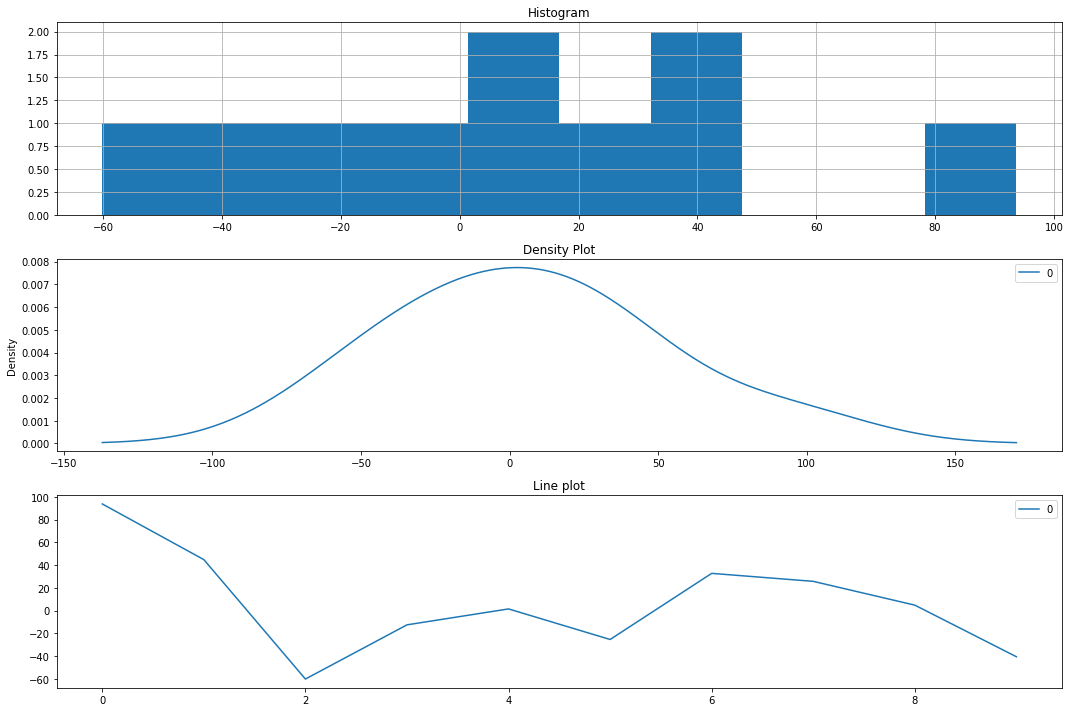

In [3]:
history = [i for i in train_data]
predictions = list()

for i in range(len(dev_data)):
     
    # Fit ARIMA model
    model = ARIMA(history, order=(11,1,0)).fit(disp=1)
    predictions.append(model.forecast()[0])
    
    # Get true values
    history.append(dev_data[i])
    
# compute residuals
residuals = pd.DataFrame([dev_data[i] - predictions[i] for i in range(len(dev_data))])

# plot residuals
plt.figure(figsize=(15,10))
plt.subplot(311)
residuals.hist(ax=plt.gca())
plt.title('Histogram')
plt.subplot(312)
residuals.plot(kind='kde', ax=plt.gca())
plt.title('Density Plot')
plt.subplot(313)
residuals.plot(kind='line', ax=plt.gca())
plt.title('Line plot')
plt.tight_layout()
plt.show()

#### Analysis (Residuals plot): 
1- It is oberserved from above residuals plots that the residuals have slightly gaussian like distribtion. But histogram is more like mixture of uniform and long tailed towards right, this hints us that we should use power transform on data before applying ARIMA.  <br>
2 - Let's check if there is any autocorelation present in the residuals.

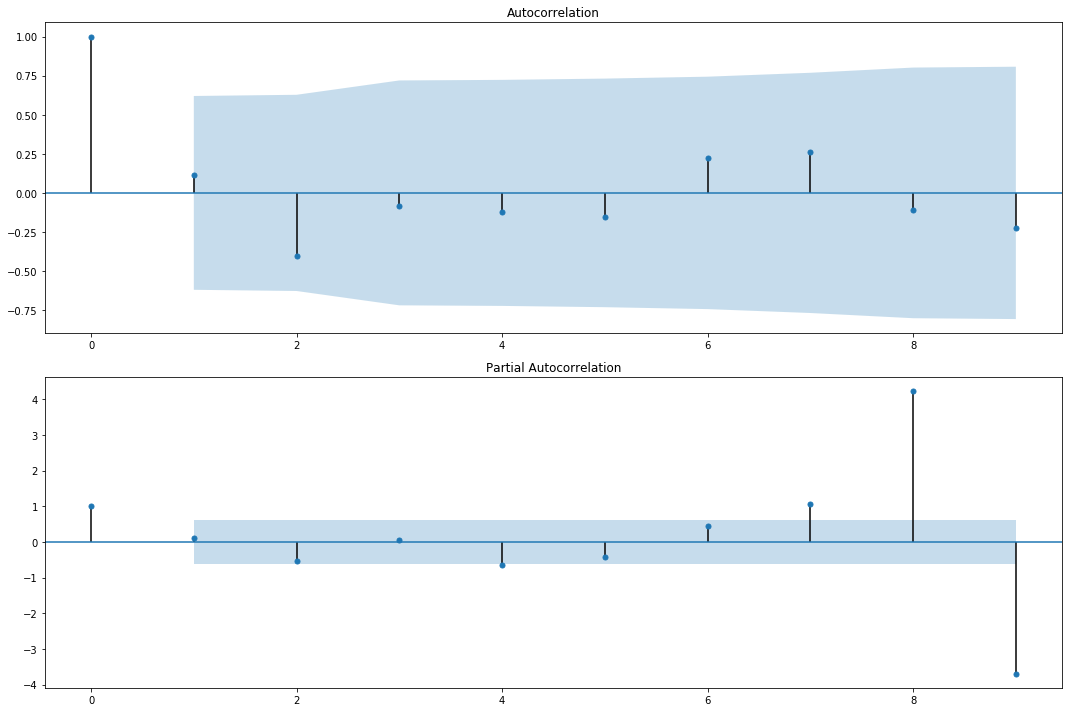

In [20]:
# Plot ACF anf PACF of residuals

plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.tight_layout()
plt.show()

### Analysis (ACF and PACF of residuals): 
1- It can be observed that majority of the autocorrelation in captured by the model.

# Power transform data 

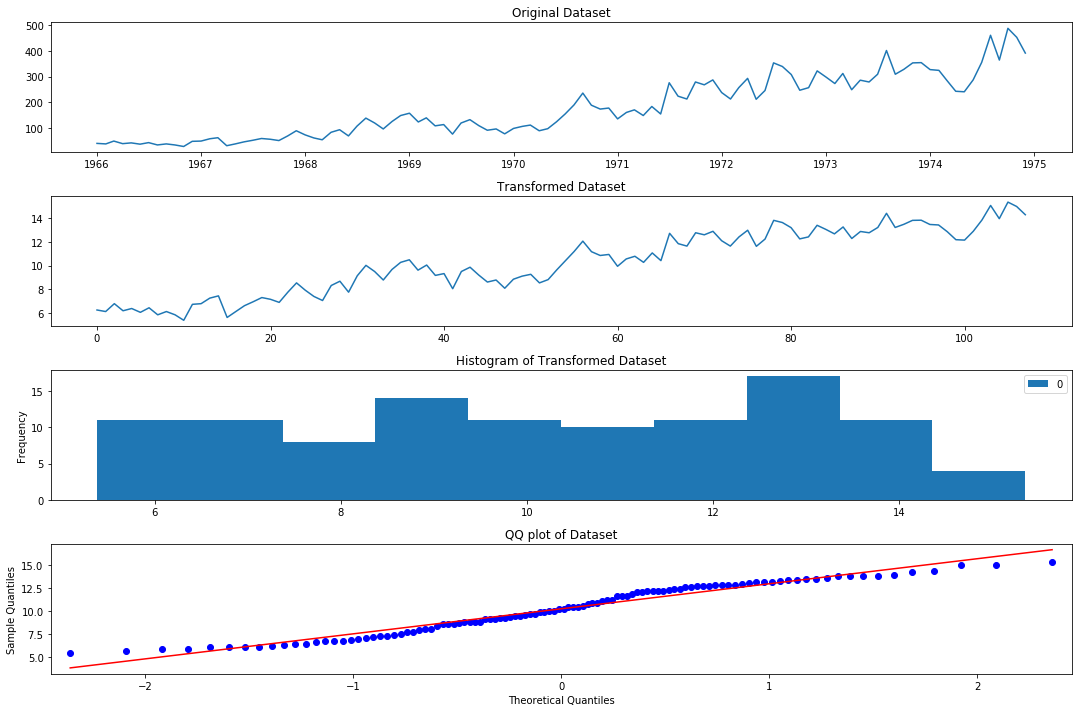

In [21]:
# Apply power transform
trfm_dataset, lmda = boxcox(train_data)

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_data)
plt.title('Original Dataset')
plt.subplot(412)
plt.plot(trfm_dataset)
plt.title('Transformed Dataset')
plt.subplot(413)
pd.DataFrame(trfm_dataset).plot(kind='hist', ax=plt.gca())
plt.title('Histogram of Transformed Dataset')
plt.subplot(414)
qqplot(trfm_dataset, line='r' ,ax=plt.gca())
plt.title('QQ plot of Dataset')
plt.tight_layout()
plt.show()

#### Analysis (After applying power transform on dataset): 
1- It can be observed that the transformed data set histogram is more like uniform. <br>
2 The Q-Q plot shows that the transformed dataset is still not perfect gaussian.<br>
3- Power transform has somewhat changed the data as noise is removed.

### ARIMA(11,1,0) on transformed dataset

In [5]:
history = [i for i in train_data]
predictions = []

def inverse_boxcox(x, lam):
    
    if lam == 0:
        return math.exp(x)
    
    return math.exp(math.log(lam * x + 1) / lam)
    

for i in range(len(dev_data)):
    
    x_trans, lm = boxcox(history)
    
    if lm < -5:
        x_trans, lm = history, 1
        
    # Fit model
    model = ARIMA(x_trans, order=(11,1,0)).fit(disp=0)
    y_pred = inverse_boxcox(model.forecast()[0], lm)
    
    
    predictions.append(y_pred)
    
    # Get true value
    history.append(dev_data[i])
    print("Predictd: %.2f  Actual: %.2f" % (y_pred, dev_data[i]))
    
print('RMSE : %.2f' % (math.sqrt(mean_squared_error(dev_data, predictions))))

Predictd: 414.11  Actual: 500.00
Predictd: 458.13  Actual: 451.00
Predictd: 448.64  Actual: 375.00
Predictd: 389.84  Actual: 372.00
Predictd: 340.60  Actual: 302.00
Predictd: 361.41  Actual: 316.00
Predictd: 360.90  Actual: 398.00
Predictd: 381.98  Actual: 394.00
Predictd: 437.78  Actual: 431.00
Predictd: 457.00  Actual: 431.00
RMSE : 43.55


#### Analysis (ARIMA with power transform): 
1- It can be observed that with power transformed dataset the ARIMA model has increased RMSE as compared to best RMSE with GRID search, but not with a drastic change. <br>
2- Let's apply grid search over ARIMA with power transformed dataset.

### GRID search on ARIMA with power transform on walk forward validation model

In [23]:
def evaluate_arima_model_power_transform(train, test, order):
    
    eval_history = [i for i in train]
    
    eval_predictions = []
    
    for i in range(len(test)):
        
        # Box transform
        train_hist, lmb = boxcox(eval_history)
        
        if lmb < -5:
            train_hist, lmb = eval_history, 1
        
        # Fit model and predict
        model = ARIMA(train_hist, order=order)
        eval_predictions.append(inverse_boxcox(model.fit(disp=0).forecast()[0], lmb))
        
        # Get y_true
        eval_history.append(test[i])
        
    # Model performance
    rmse = np.sqrt(mean_squared_error(test, eval_predictions))
    return rmse

In [24]:
# Function for grid searchon ARIMA with power transform
def grid_ARIMA_power_transform(p_values, d_values, q_values):
    
    best_rmse, best_cfg = float('inf'), None
    
    for i in p_values:
        for j in d_values:
            for k in q_values:                    
                
                try:
                    
                    grid_rmse = evaluate_arima_model_power_transform(train_data, dev_data, (i,j,k))
                    
                    if grid_rmse < best_rmse:
                        best_rmse, best_cfg = grid_rmse, (i,j,k)
                    print('Got RMSE: %.2f ARIMA CFG : p:%s, d:%s and q:%s' % (grid_rmse, i,j,k))
                    
                except:
                    continue
                
    print('Best RMSE: %.2f with ARIMA(p:%s, d:%s, q:%s)' % (best_rmse, best_cfg[0], best_cfg[1], best_cfg[2]))

In [25]:
grid_ARIMA_power_transform(p,d,q)

Got RMSE: 248.14 ARIMA CFG : p:0, d:0 and q:0
Got RMSE: 156.88 ARIMA CFG : p:0, d:0 and q:1
Got RMSE: 130.87 ARIMA CFG : p:0, d:0 and q:2
Got RMSE: 58.23 ARIMA CFG : p:0, d:1 and q:0
Got RMSE: 58.00 ARIMA CFG : p:0, d:1 and q:1
Got RMSE: 57.25 ARIMA CFG : p:0, d:1 and q:2
Got RMSE: 62.97 ARIMA CFG : p:0, d:1 and q:3
Got RMSE: 55.60 ARIMA CFG : p:0, d:1 and q:4
Got RMSE: 55.67 ARIMA CFG : p:0, d:1 and q:5
Got RMSE: 96.23 ARIMA CFG : p:0, d:2 and q:0
Got RMSE: 58.85 ARIMA CFG : p:0, d:2 and q:1
Got RMSE: 58.34 ARIMA CFG : p:1, d:0 and q:0
Got RMSE: 56.45 ARIMA CFG : p:1, d:0 and q:1
Got RMSE: 56.83 ARIMA CFG : p:1, d:1 and q:0
Got RMSE: 56.86 ARIMA CFG : p:1, d:1 and q:1
Got RMSE: 56.82 ARIMA CFG : p:1, d:1 and q:2
Got RMSE: 79.05 ARIMA CFG : p:1, d:2 and q:0
Got RMSE: 56.79 ARIMA CFG : p:2, d:0 and q:0
Got RMSE: 56.21 ARIMA CFG : p:2, d:1 and q:0
Got RMSE: 56.84 ARIMA CFG : p:2, d:1 and q:1
Got RMSE: 55.61 ARIMA CFG : p:2, d:2 and q:0
Got RMSE: 57.04 ARIMA CFG : p:2, d:2 and q:1
Got RMS

### Analysis (Grid search ARIMA with power transform): 
1- It can be observed that applying power transform on the dataset to remove noise, better exposes the data developed by the underlying process to ARIMA model.<br>
2- We see that we got bests RMSE with ARIMA(10,1,2), which was observed from the initial ACF and PACF plot.

### Analyze residuals on ARIMA(10,1,2) with noise removed from the data using power transform

In [6]:
history = [i for i in train_data]
prediction = list()

# walk forward validation model
for i in range(len(dev_data)):
    
    # remove noise
    x_train , lm_val = boxcox(history)
    
    if lm_val < -5 :
        x_train , lm_val = history, 1
        
    # Fit model and get predictions
    model_fitted = ARIMA(x_train, order=(10,1,2)).fit(disp=0)
    y_pred = inverse_boxcox(model_fitted.forecast()[0], lm_val)    
    prediction.append(y_pred)
    
    # Append history
    history.append(dev_data[i])
    
    print('Predicted: %.2f Actual: %.2f' % (y_pred, dev_data[i]))
    
print('RMSE: %.2f' % (math.sqrt(mean_squared_error(dev_data, prediction))))

Predicted: 414.41 Actual: 500.00
Predicted: 451.71 Actual: 451.00
Predicted: 437.79 Actual: 375.00
Predicted: 385.40 Actual: 372.00
Predicted: 343.70 Actual: 302.00
Predicted: 371.76 Actual: 316.00
Predicted: 377.44 Actual: 398.00
Predicted: 397.59 Actual: 394.00
Predicted: 440.43 Actual: 431.00
Predicted: 443.56 Actual: 431.00
RMSE: 41.21


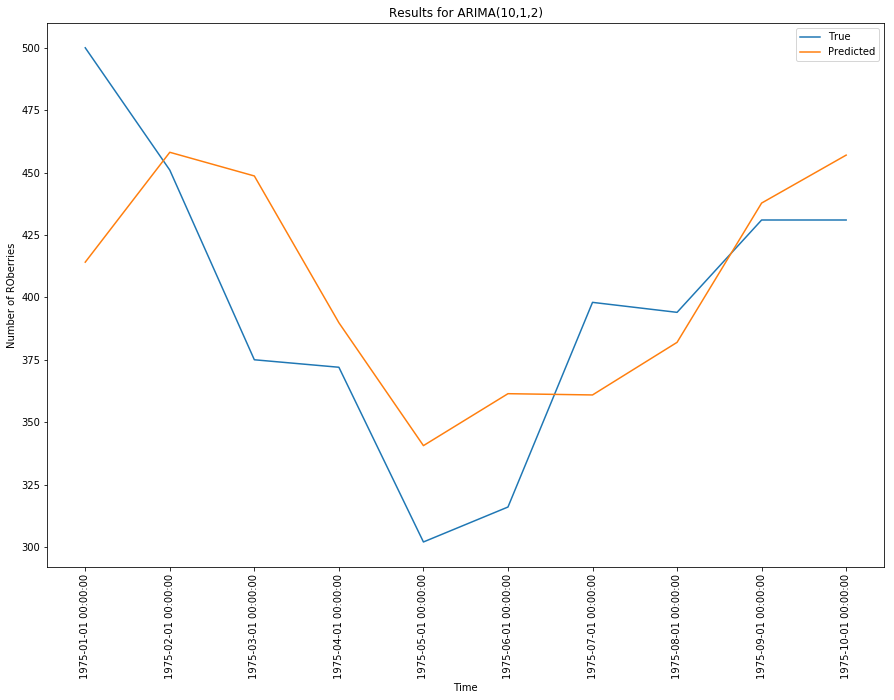

In [80]:
plt.figure(figsize=(15,10))
plt.plot(dev_data.values, label='True')
plt.plot(predictions, label='Predicted')
plt.xticks(np.linspace(0,9, 10), dev_data.index, rotation=90 )
plt.ylabel('Number of ROberries')
plt.xlabel('Time')
plt.legend()
plt.title('Results for ARIMA(10,1,2)')
plt.show()

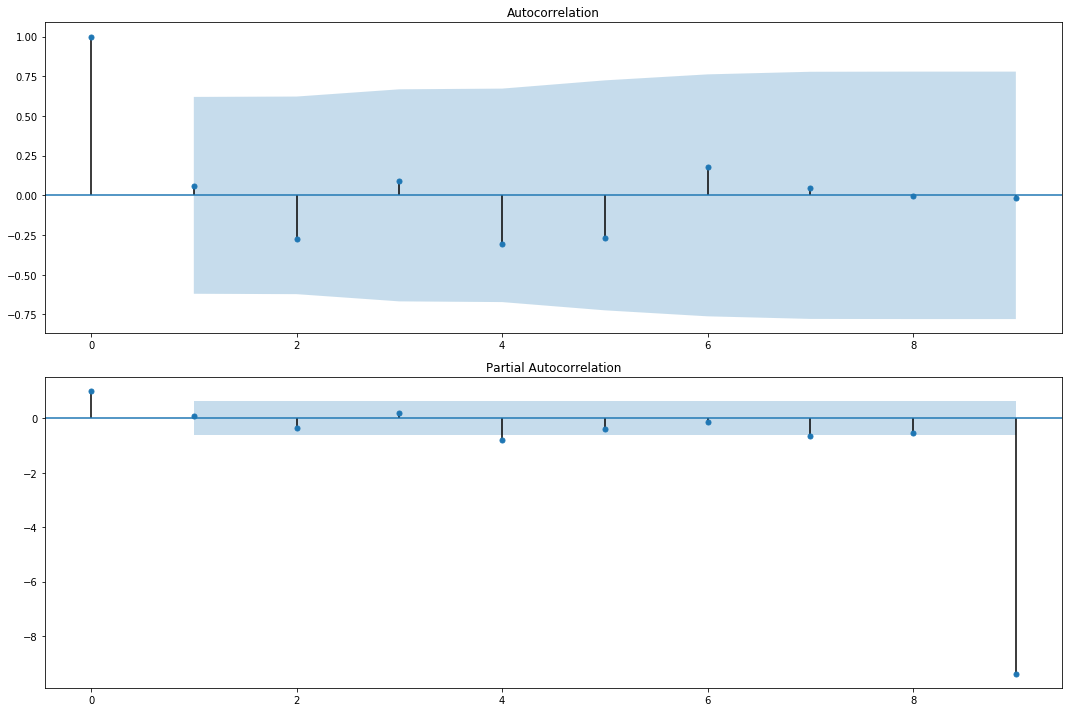

In [81]:
# compute residuals
final_arima_rsd = [dev_data[i] - prediction[i] for i in range(len(dev_data))]

# plot residuals
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(final_arima_rsd, ax=plt.gca())
plt.subplot(212)
plot_pacf(final_arima_rsd, ax=plt.gca())
plt.tight_layout()
plt.show()

### Analysis (ACF and PACF of residuals of ARIMA on power transformed dataset): 
1- It can be observed that majority of the autocorrelation in captured by the model.

## Hence, best ARIMA configuration that can capture the latent structure for this data turns out to be ARIMA(10,1,2)